# 期末專題：團體（多人）人臉辨識

# 姓名：林佳何

#學號：00957028

#動機：看到LAB5人臉辨識的抓人臉和五官範例，抓得到多個人的人臉，但在後面的範例卻只辨識一個人，覺得有點可惜，想試試看多人辨識的效果


先導入所需函式庫與套件，包含系統使用的、抓五官的、訓練模型的、畫圖的、處理影像的以及模型

In [1]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import os
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
import cv2
import numpy as np
import pickle
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
try:
    import mtcnn
except:
    !pip install mtcnn    
    import mtcnn
print(mtcnn.__version__)

#載入facenet模型
_URL = 'https://github.com/satinder147/Attendance-using-Face/raw/master/facenet_keras.h5'
local_path_to_facenet_h5 = tf.keras.utils.get_file('facenet_keras.h5',origin=_URL,cache_subdir='models',extract=False)
facenet = load_model(local_path_to_facenet_h5)

#展示facenet的架構
facenet_arch = tf.keras.utils.plot_model(facenet, to_file='facenet.png',show_shapes=True, show_layer_names=True, dpi=64)
display(facenet_arch)
#創造mtcnn人臉偵測
detector = mtcnn.MTCNN()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.3 MB 30.1 MB/s 
0.1.0
92413952/92397640 [==============================] - 0s 0us/step


自己設計一個資料集，關於那個範例圖片團體的，訓練集一人二十張，驗證集一人五張

這裡的解壓縮解決一個我原本在LAB5的問題

問題：無法把資料夾放進Colab，要慢慢創資料夾，並一個一個放進去，非常費時且當時沒有解法

解法：將資料夾先壓縮起來並放進Colab，再在Colab裡解壓縮

In [2]:
!unzip 9-twice-member.zip

Archive:  9-twice-member.zip
   creating: 9-twice-member/
   creating: 9-twice-member/train/
   creating: 9-twice-member/train/chaeyoung/
  inflating: 9-twice-member/train/chaeyoung/  (1).jpg  
  inflating: 9-twice-member/train/chaeyoung/  (10).jpg  
  inflating: 9-twice-member/train/chaeyoung/  (11).jpg  
  inflating: 9-twice-member/train/chaeyoung/  (12).jpg  
  inflating: 9-twice-member/train/chaeyoung/  (13).jpg  
  inflating: 9-twice-member/train/chaeyoung/  (14).jpg  
  inflating: 9-twice-member/train/chaeyoung/  (15).jpg  
  inflating: 9-twice-member/train/chaeyoung/  (16).jpg  
  inflating: 9-twice-member/train/chaeyoung/  (17).jpg  
  inflating: 9-twice-member/train/chaeyoung/  (18).jpg  
  inflating: 9-twice-member/train/chaeyoung/  (19).jpg  
  inflating: 9-twice-member/train/chaeyoung/  (2).jpg  
  inflating: 9-twice-member/train/chaeyoung/  (20).jpg  
  inflating: 9-twice-member/train/chaeyoung/  (3).jpg  
 extracting: 9-twice-member/train/chaeyoung/  (4).jpg  
  inflating

偵測人臉和訓練模型的所需函式

In [3]:
def get_face_embedding(facenet,face_image):
    face_image = (face_image-tf.math.reduce_mean(face_image))/tf.math.reduce_std(face_image)
    embedding = facenet.predict(face_image[tf.newaxis,:])
    embedding = embedding/tf.norm(embedding)
    return embedding
def generate_examples(gendata):
    train_x = []
    train_y = []
    for idx, (filename, y) in enumerate(zip(gendata.filenames,gendata.classes)):        
        x_img = tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(os.path.join(gendata.directory,filename)))
        results = detector.detect_faces(x_img)
        if len(results)>0:
            x1, y1, width, height = results[0]['box']
            x1, y1 = abs(x1), abs(y1)
            x2, y2 = x1 + width, y1 + height
            face = tf.image.resize(x_img[y1:y2,x1:x2],(160,160)) 
            embedding = get_face_embedding(facenet,face)
            train_x.append(embedding)
            train_y.append(y)
    return tf.concat(train_x,axis=0),tf.constant(np.array(train_y))

def def_face_recognition_model(class_indices):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input((128,)))
    model.add(tf.keras.layers.Dense(len(class_indices),activation='softmax'))        
    adam = tf.keras.optimizers.Adam()
    model.compile(loss='sparse_categorical_crossentropy',optimizer=adam,metrics=['accuracy'])
    model.person_name = {v:k for k,v in class_indices.items()}
    return model

def face_recognition(facenet,classifier,face_image):
    embedding = get_face_embedding(facenet,face_image)
    prob      = classifier.predict(embedding)
    name      = classifier.person_name[tf.math.argmax(prob,axis=1).numpy()[0]]      
    return name

創造訓練和驗證的Generator

In [4]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

dataset_folder = './9-twice-member/'
train_generator = train_datagen.flow_from_directory(dataset_folder +'train',batch_size=1)
valid_generator = train_datagen.flow_from_directory(dataset_folder +'val',batch_size=1)

train_x,train_y = generate_examples(train_generator)
valid_x,valid_y = generate_examples(valid_generator)

Found 180 images belonging to 9 classes.
Found 45 images belonging to 9 classes.


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


寫進模型

In [5]:
model = def_face_recognition_model(train_generator.class_indices)
history = model.fit(train_x,train_y,batch_size=13,validation_data=(valid_x,valid_y),epochs=30,verbose=1)

Epoch 1/30
14/14 [==============================] - 1s 14ms/step - loss: 2.1978 - accuracy: 0.0894 - val_loss: 2.1777 - val_accuracy: 0.1111
Epoch 2/30
14/14 [==============================] - 0s 4ms/step - loss: 2.1567 - accuracy: 0.1844 - val_loss: 2.1417 - val_accuracy: 0.3333
Epoch 3/30
14/14 [==============================] - 0s 4ms/step - loss: 2.1180 - accuracy: 0.3128 - val_loss: 2.1069 - val_accuracy: 0.4000
Epoch 4/30
14/14 [==============================] - 0s 3ms/step - loss: 2.0801 - accuracy: 0.4413 - val_loss: 2.0731 - val_accuracy: 0.5111
Epoch 5/30
14/14 [==============================] - 0s 3ms/step - loss: 2.0435 - accuracy: 0.5531 - val_loss: 2.0391 - val_accuracy: 0.5333
Epoch 6/30
14/14 [==============================] - 0s 3ms/step - loss: 2.0070 - accuracy: 0.6480 - val_loss: 2.0062 - val_accuracy: 0.6444
Epoch 7/30
14/14 [==============================] - 0s 4ms/step - loss: 1.9710 - accuracy: 0.7821 - val_loss: 1.9732 - val_accuracy: 0.7333
Epoch 8/30
14/14 [=

圖形化顯示訓練與驗證的準確度和損失值

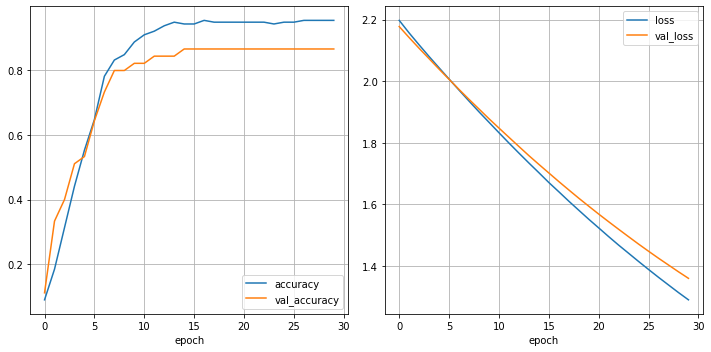

In [6]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.xlabel('epoch')
plt.grid(True)
plt.axis(True)
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()
plt.grid(True)
plt.axis(True)
plt.xlabel('epoch')
plt.tight_layout()
plt.show()

儲存模型

In [7]:
model.save('face_model.twice')
with open('face_model.pickle','wb') as f:
    pickle.dump(model.person_name,f)

INFO:tensorflow:Assets written to: face_model.twice/assets


載入模型

In [8]:
cmodel = tf.keras.models.load_model('face_model.twice')
with open('face_model.pickle','rb') as f:
    cmodel.person_name = pickle.load(f)

隨機抽五個驗證集的資料來看訓練模型的效果

並使用不同的顏色區分不同的人，視覺上有更好的體驗

執行結果：測試時，五張無錯誤

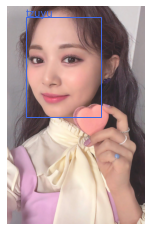

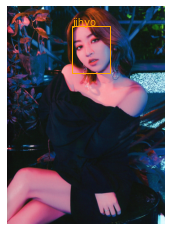

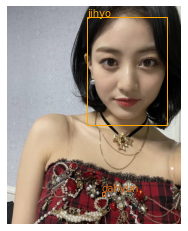

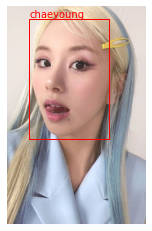

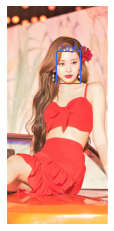

In [9]:
import matplotlib.patches as mpatches
#每個人臉辨識的顏色
color_num ={
    'tzuyu' : 'royalblue',
    'jihyo' : 'orange',
    'sana' : 'mediumpurple',
    'mina' : 'aquamarine',
    'dahyun' : 'chocolate',
    'jeongyeon' : 'chartreuse',
    'chaeyoung' : 'red',
    'nayeon' : 'dodgerblue',
    'momo' : 'hotpink',
    }

for r_idx in np.random.permutation(len(valid_generator.filenames))[:5]:
    
    #載入影像
    filename =valid_generator.filenames[r_idx]
    x_img = tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(os.path.join(valid_generator.directory,filename)))
    plt.figure()
    ax = plt.gca()
    plt.imshow(x_img/255)

    #人臉偵測
    results = detector.detect_faces(x_img)
    
    #辨識人臉
    for b in results:
        x1, y1, width, height = b['box']
        x1, y1 = abs(x1), abs(y1)
        x2, y2 = x1 + width, y1 + height
        
        face      = tf.image.resize(x_img[y1:y2,x1:x2],(160,160)) 
        
        name      = face_recognition(facenet,cmodel,face)
        
        ax.add_patch(mpatches.Rectangle((x1, y1),width, height, ec=color_num[name],alpha=1, fill=None))
        plt.text(x1,y1-5, name,color=color_num[name])
        
    plt.axis(False)
    plt.show()

# 主題

把那張範例圖片拿去來用訓練模型進行辨識

執行結果：完美地辨識出九個人的人臉並沒有誤認


647168/637512 [==============================] - 0s 0us/step


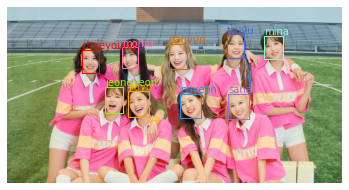

In [10]:
from google.colab import files
#載入影像
url  ='https://a.ksd-i.com/a/2020-01-01/123159-803538.jpg'
name = url.split('/')[-1]
filename = tf.keras.utils.get_file(name,origin=url)
x_img = tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(os.path.join(valid_generator.directory,filename)))
plt.figure()
ax = plt.gca()
plt.imshow(x_img/255)

#人臉偵測
results = detector.detect_faces(x_img)
    
#辨識人臉
for b in results:
  x1, y1, width, height = b['box']
  x1, y1 = abs(x1), abs(y1)
  x2, y2 = x1 + width, y1 + height
      
  face      = tf.image.resize(x_img[y1:y2,x1:x2],(160,160)) 
        
  name      = face_recognition(facenet,cmodel,face)
        
  ax.add_patch(mpatches.Rectangle((x1, y1),width, height, ec = color_num[name],alpha=1, fill=None))
  plt.text(x1,y1-5, name,color=color_num[name])
        
plt.axis(False)
plt.show()

再辨識看看其他團體照

執行結果：五張中有一人認錯、一鏡頭認為人

147456/132909 [=================================] - 0s 0us/step


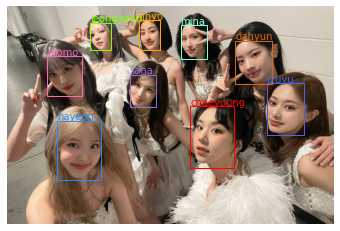

966656/957194 [==============================] - 0s 1us/step


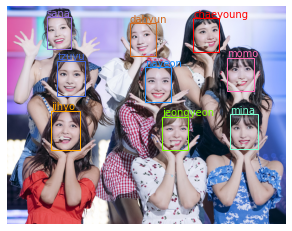

73728/58529 [=====================================] - 0s 0us/step


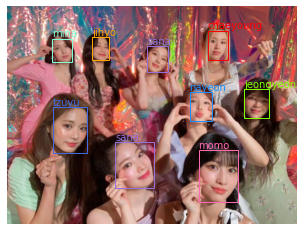

1474560/1459402 [==============================] - 1s 1us/step


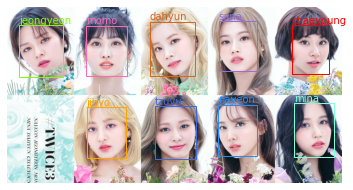

1179648/1168684 [==============================] - 0s 0us/step


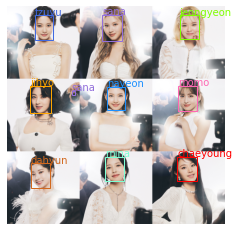

In [11]:
url = []
url.append('https://pgw.udn.com.tw/gw/photo.php?u=https://uc.udn.com.tw/photo/2022/05/22/realtime/17091342.jpg&s=Y&x=0&y=9&sw=1279&sh=852&exp=3600')
url.append('https://upload.wikimedia.org/wikipedia/commons/f/f4/180717_%EC%97%B4%EB%A6%B0%EC%9D%8C%EC%95%85%ED%9A%8C_%ED%8A%B8%EC%99%80%EC%9D%B4%EC%8A%A4_02.jpg')
url.append('https://s.yimg.com/ny/api/res/1.2/mkhOQafxGG3m74QvCv4gtA--/YXBwaWQ9aGlnaGxhbmRlcjt3PTY0MDtoPTQ4MA--/https://s.yimg.com/uu/api/res/1.2/ir_KmWWTWwkO4VlKVH9vIw--~B/aD02MDA7dz04MDA7YXBwaWQ9eXRhY2h5b24-/https://media.zenfs.com/en/nownews.com/da4bb97d6dc53963bcdfa83418d8a0d1')
url.append('https://a.ksd-i.com/a/2020-09-17/130156-874115.png')
url.append('https://www.kpopdays.com/wp-content/uploads/2022/04/TW05-21.jpg')

for i in range(len(url)):
    
    #載入影像
    name = url[i].split('/')[-1]
    filename = tf.keras.utils.get_file(name,origin=url[i])
    x_img = tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(os.path.join(valid_generator.directory,filename)))
    plt.figure()
    ax = plt.gca()
    plt.imshow(x_img/255)

    #人臉偵測
    results = detector.detect_faces(x_img)
    
    #辨識人臉
    for b in results:
        x1, y1, width, height = b['box']
        x1, y1 = abs(x1), abs(y1)
        x2, y2 = x1 + width, y1 + height
        
        face      = tf.image.resize(x_img[y1:y2,x1:x2],(160,160)) 
        
        name      = face_recognition(facenet,cmodel,face)

        ax.add_patch(mpatches.Rectangle((x1, y1),width, height, ec=color_num[name],alpha=1, fill=None))
        plt.text(x1,y1-5, name,color=color_num[name])
        
    plt.axis(False)
    plt.show()

心得：我在想專題題目時，實在想不到要做什麼，翻翻以前的LAB，才找到這個蠻有興趣的主題，也疑惑為什麼當時人臉辨識範例沒有做多人辨識，我猜可能是要花比較多時間去訓練之類的，再來做資料集本來想用爬蟲來抓圖片的，但想抓的網站嚴厲禁止爬蟲，所以最後是人工抓取近兩敗張圖片，挺累人的，最後做出來的模型辨識範例的結果真的是就完美，沒有任何錯誤，但在之後網路上找的五張圖片有些錯誤，不過辨識成功率也敢符合算出來的八成多，也在這次做專題的時候找到以前沒解決的問題，並找到方法解決，蠻有收穫的，謝謝老師，也辛苦批改的各位了！